Theodoros Kassa Aragie

251163893

ECE 9309

Prof. Soodeh Nikan

February 17, 2025

# Implementing Agglomerative Clustering for a Recommender System

Database: https://www.kaggle.com/datasets/nechbamohammed/research-papers-dataset

In [1]:
# Misc Imports
import os
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from helper import *

# SciKit-Learn Imports
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering 
import scipy.cluster.hierarchy as shc 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer

# Tensorflow/Keras Imports
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
import tensorflow as tf
import tensorflow_hub as hub
import keras

# Restrict TensorFlow to only use the /GPU:0
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# Set default Tensor type to double (float64)
keras.backend.set_floatx('float64')

# Ensure folders are ready
if not os.path.isdir("./dump"):
    os.makedirs("./dump")
if not os.path.isdir("./images"):
    os.makedirs("./images")

# Prepare the Universal Sentence Encoder (USE)
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2025-03-26 15:25:25.855546: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 15:25:25.864253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743017125.873637   59132 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743017125.876323   59132 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743017125.884016   59132 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

1 Physical GPUs, 1 Logical GPU


I0000 00:00:1743017127.059049   59132 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1743017127.059999   59132 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6168 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Load Preprocessed Data

In [2]:
# Load cleaned DF
cleanedDF:pd.DataFrame = pd.read_csv(
    "database_clean.csv"
)

# Load USE embeddings from cleaned dataset
embeddingsDF:pd.DataFrame = pd.read_csv(
    "use_embeddings.csv"
).drop(columns=["id"])

# Train 90%, Test 10%
# Calculate the training portion and the remainder
trnDF, tstDF = train_test_split(
    # No need to split into X and Y
    embeddingsDF, test_size=0.1, random_state=42
)
print(f"Trn: {trnDF.shape}, Tst: {tstDF.shape}")

# Compress via PCA to 2 features for AC plot:
pca:PCA = PCA(n_components=2).fit(trnDF)
trnComp:pd.DataFrame = pd.DataFrame(
    pca.transform(trnDF), columns=["P1", "P2"]
)
tstComp:pd.DataFrame = pd.DataFrame(
    pca.transform(tstDF), columns=["P1", "P2"]
)

Trn: (9958, 512), Tst: (1107, 512)


## Visualize Data and Tune for Best Agglomerative Clustering Model

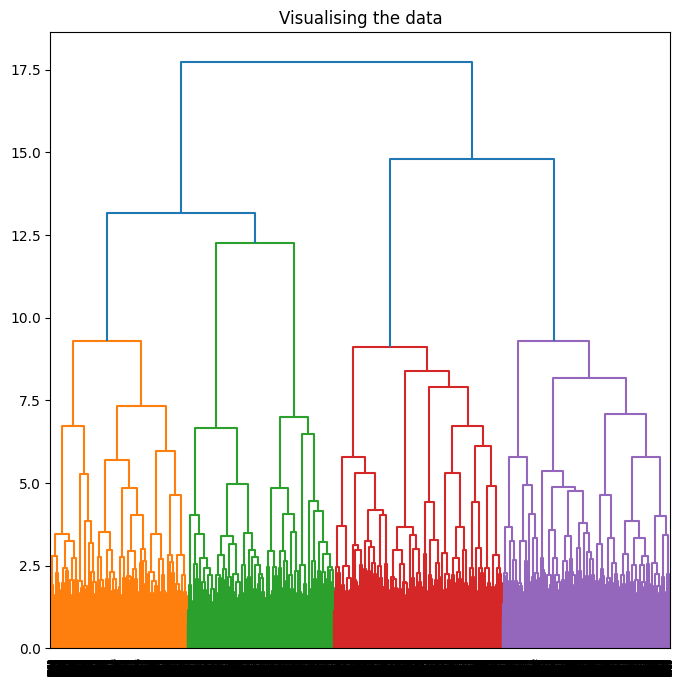

In [3]:
# Dendrogram
plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(trnDF, method ='ward')))
plt.savefig(
    "./images/001_dendrogram.png", bbox_inches='tight', dpi=100
)

In [4]:
# Custom wrapper for AgglomerativeClustering
# (to work with GridSearchCV)
class AgglomerativeClusteringCV(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters:int=2):
        # Set hyperparameters depending on inputted fields
        self.n_clusters = n_clusters
        self.model = None
    def fit(self, X, y=None):
        # AC model with current selection of hyperparameters
        self.model = AgglomerativeClustering(
            n_clusters=self.n_clusters,
        )
        # Fit and store cluster labels
        self.labels_ = self.model.fit_predict(X)
        return self
    def fit_predict(self, X, y=None):
        return self.fit(X).labels_

# Custom Silhouette Scorer
def silhScorer(estimator:AgglomerativeClusteringCV, X:npt.NDArray):
    # Get cluster labels
    labels:npt.NDArray = estimator.fit_predict(X)
    # Need at least 2 clusters)
    if len(set(labels)) < 2:
        return -1
    return silhouette_score(X, labels)

# Define Hyperparameter Grid
paramGrid:dict[str, list] = {
    # Number of clusters to search
    'n_clusters': [2 + i for i in range(9)],
}

# Check if search was already saved, otherwise run it
gridSearch:GridSearchCV
if not os.path.isfile("./dump/gridSearch.pkl"):
    gridSearch = GridSearchCV(
        estimator=AgglomerativeClusteringCV(),
        param_grid=paramGrid,
        scoring=silhScorer, # Use custom Silhouette Score function
        cv=3, # 3-fold cross-validation
        n_jobs=-1 # Use max CPU cores possible
    )
    # Fit GridSearch
    gridSearch.fit(trnDF)
    # Save it for later
    joblib.dump(gridSearch, "./dump/gridSearch.pkl")
else:
    gridSearch = joblib.load("./dump/gridSearch.pkl")

# Best Parameters & Score
print("Best Parameters:", gridSearch.best_params_)
print("Best Silhouette Score:", gridSearch.best_score_)
bestN:int = gridSearch.best_params_["n_clusters"]

Best Parameters: {'n_clusters': 2}
Best Silhouette Score: 0.01900548233886569


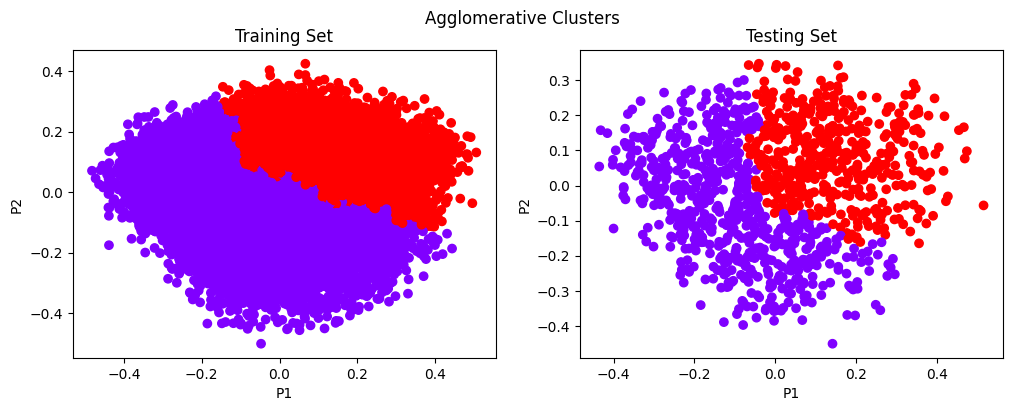

In [5]:
# Instantiate optimal AC model
bestAC:AgglomerativeClustering = AgglomerativeClustering(
    **gridSearch.best_params_
)
# Calculate labels
trnLabels:npt.NDArray = bestAC.fit_predict(trnComp)
tstLabels:npt.NDArray = bestAC.fit_predict(tstComp)

# Plotting optimial AC clusters
plt.figure(figsize=(12, 4))
plt.suptitle("Agglomerative Clusters")
plt.subplot(1, 2, 1)
plt.scatter(
    trnComp["P1"], trnComp["P2"], 
    c=trnLabels,
    cmap="rainbow"
)
plt.xlabel("P1")
plt.ylabel("P2")
plt.title("Training Set")
plt.subplot(1, 2, 2)
plt.scatter(
    tstComp["P1"], tstComp["P2"], 
    c=tstLabels,
    cmap="rainbow"
)
plt.xlabel("P1")
plt.ylabel("P2")
plt.title("Testing Set")
plt.savefig(
    "./images/002_agg_clusters.png", bbox_inches='tight', dpi=100
)
plt.show()

## Make Recomendations, Plot Cosine Similarity, Save Model

Top 10 papers for paper 0:
                                               abstract  \
7342  ABSTRACTThe emergence and popularity of new co...   
7978  Introduction Emotions influence our behavior (...   
3750  Abstract  Introduction  Secure messaging is a ...   
9413  Abstract Do cyberattacks fuel the politics of ...   
847   A model of the dynamics of self-regulation des...   
3267  An effective change in Human Computer Interact...   
29    The goal of this study is to design a new self...   
1087  On social media, users can easily share their ...   
5828  As information on the Internet grows exponenti...   
7100  Abuse in any form is a grave threat to a child...   

                                                authors  n_citation  \
7342               ['Mario Liong', 'Grand H.-L. Cheng']           0   
7978  ['Adriana Peña', 'Nora Rangel', 'Mirna Muñoz',...           0   
3750  ['Peter Hoonakker', 'Pascale Carayon', 'Randi ...           0   
9413  ['Daphna Canetti', 'Michael L. Gr

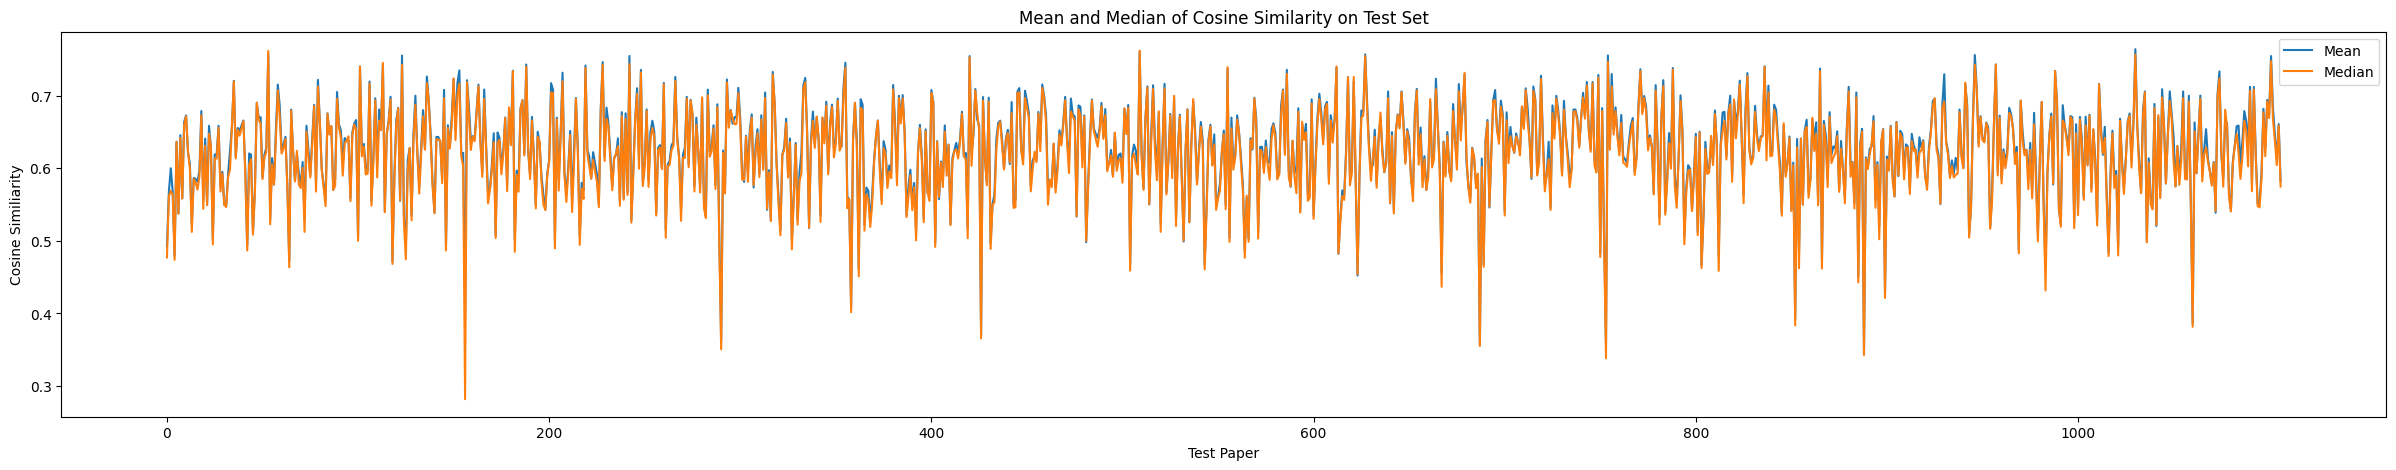

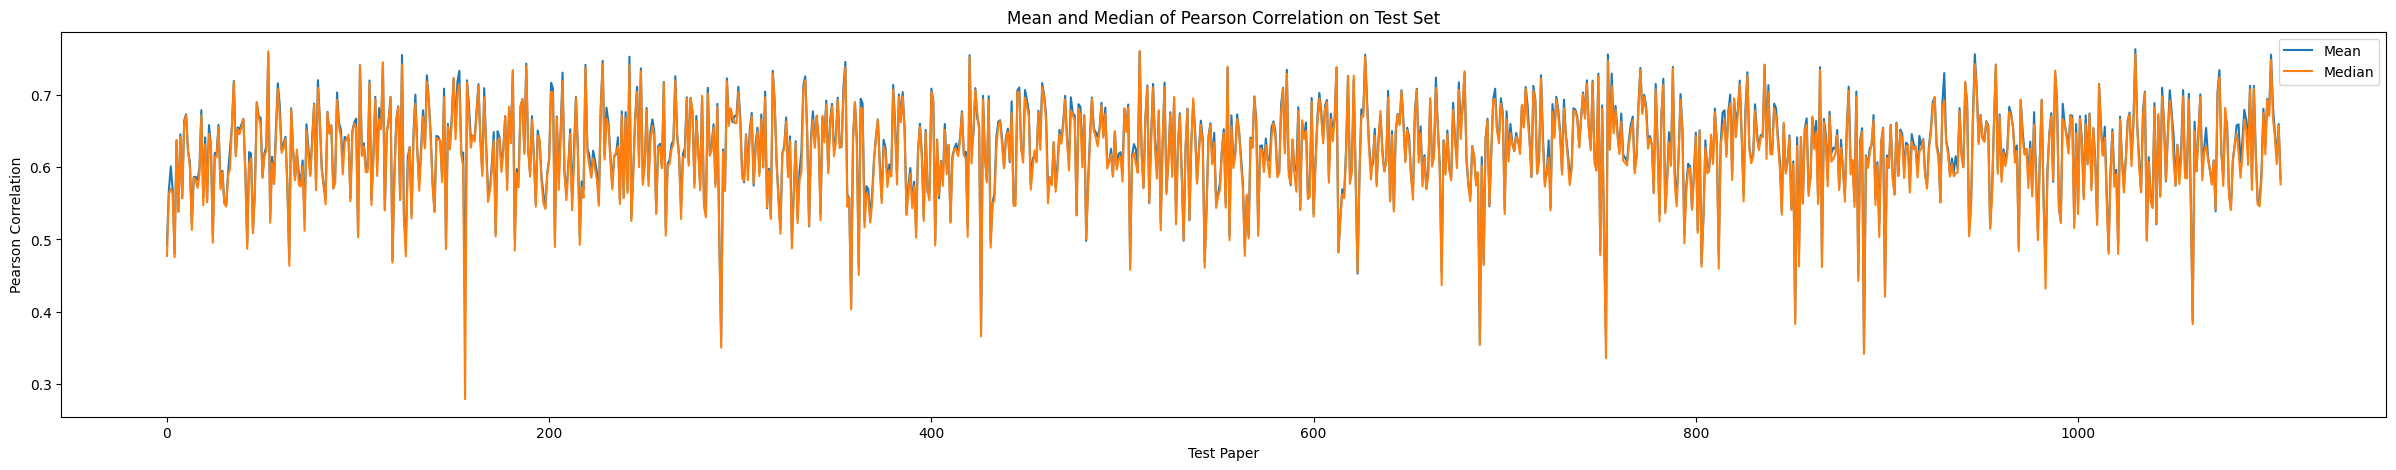

In [6]:
# Reset best AC model and fit to train data only
bestAC = AgglomerativeClustering(
    **gridSearch.best_params_
)
bestAC.fit(trnDF)
trnDF["cluster"] = bestAC.labels_

# Function to recommend top n papers (default to top_n=10)
def recommendPapers(top_n:int=10):
    # Define lists
    corrMeanList:list[float] = []
    corrMedList:list[float] = []
    simsList:list[npt.NDArray] = []
    cosMeanList:list[float] = []
    cosMedList:list[float] = []
    topList:list[list[int]] = []
    tfidfList:list[npt.NDArray] = []
    testVecList:list[npt.NDArray] = []
    topVecList:list[npt.NDArray] = []
    # For each paper in the test set
    # (so tstDF shape from before adding the cluster column):
    for testPaperIndex in range(tstDF.shape[0]):
        # Get test embeddings for current test paper
        testEmbeddings:npt.NDArray = tstDF.iloc[
            testPaperIndex
        ].values.reshape(1, -1)
        # Determine the closest cluster for the current test paper
        distances:list = []
        for clusterID in range(bestN):
            clusterPoints:pd.DataFrame = trnDF.drop(
                columns=["cluster"]
            ).loc[trnDF["cluster"] == clusterID]
            centroid:npt.NDArray = np.array(
                np.mean(clusterPoints, axis=0)
            ).reshape(1, -1)
            currDist:float = euclidean_distances(
                testEmbeddings,
                centroid
            )[0][0]
            distances.append(currDist)
        closestCluster:float = np.argmin(distances)
        # Get similarities of all training papers in the same cluster
        sameClusterPapers:pd.DataFrame = trnDF.drop(
            columns=["cluster"]
        )[trnDF["cluster"] == closestCluster]
        currSims:npt.NDArray = cosine_similarity(
            testEmbeddings,
            sameClusterPapers.values
        )[0]
        # Get top-N most similar papers, highest similarity first
        topIndices:npt.NDArray = np.argsort(currSims)[::-1][:top_n]
        topPapers:list[int] = sameClusterPapers.iloc[
            topIndices
        ].index.tolist()
        topEmbeddings:npt.NDArray = sameClusterPapers.iloc[
            topIndices
        ].values

        # Print top 10 recommendations for current paper:
        print(f"Top 10 papers for paper {testPaperIndex}:")
        print(cleanedDF.iloc[topPapers])

        # Compute cosine similarity against top papers
        similarities:npt.NDArray = cosine_similarity(
            testEmbeddings,
            topEmbeddings
        )
        # Pearson correlation
        corrMean, corrMedian = compute_pearson_correlation(
            testEmbeddings,
            topEmbeddings.reshape(1, top_n, -1)
        )
        # Cosine similarity score 
        cosMean, cosMedian = cosine_similarity_mean_median(similarities)
        # TF-IDF
        (
            tfidfTestMatrix, testVectors, topRecommendedVectors
        ) = compute_tfidf_similarity(
            test_texts=cleanedDF.loc[[0], "abstract"].tolist(),
            top10_texts=[cleanedDF.loc[idx, "abstract"] for idx in topPapers]
        )
        # Store values for each index
        corrMeanList.append(corrMean[0])
        corrMedList.append(corrMedian[0])
        simsList.append(similarities[0])
        cosMeanList.append(cosMean[0])
        cosMedList.append(cosMedian[0])
        topList.append(topPapers)
        tfidfList.append(tfidfTestMatrix)
        testVecList.append(testVectors)
        topVecList.append(topRecommendedVectors)
    # Plots:
    plot_cosine_similarity(cosMeanList, cosMedList)
    plot_pearson_correlation(corrMeanList, corrMedList)
    # Return data
    return pd.DataFrame({
        "correlation_mean": corrMeanList,
        "correlation_median": corrMedList,
        "cosine_similarity": simsList,
        "cosine_mean": cosMeanList,
        "cosine_median": cosMedList,
        "top_paper_indices": topList,
        "tfidf_matrix": tfidfList,
        "test_vectors": testVecList,
        "top_vectors": topVecList
    })
# Example usage on a query string
recDF:pd.DataFrame= recommendPapers(top_n=10)
recDF[[
    "correlation_mean", "correlation_median", "cosine_mean",
    "cosine_median", "top_paper_indices"
]].to_csv("./dump/recs.csv")

In [7]:
# Save the trained model
joblib.dump(bestAC, "./dump/acModel.pkl")

['./dump/acModel.pkl']

## Test Loaded Model with a Query String

In [8]:
# Reload the model
loadedModel:AgglomerativeClustering = joblib.load("./dump/acModel.pkl")

Top 10 papers for query 'stochastic hybrid system modeling':
                                               abstract  \
688   The vast majority of stochastic simulation mod...   
9265  This paper addresses the online modeling for t...   
1564  This paper proposes a scenario-based stochasti...   
7014  This paper addresses the problem of adaptive f...   
1790  In process engineering, the breakage behavior ...   
185   Many real world problems can be modeled by a l...   
6611  We present a general framework, the coupled co...   
4623  Multi-view modeling is a system design methodo...   
5482  Rule-based modeling with BioNetGen has been wi...   
5157  The paper presents the dynamic modeling of Mul...   

                                                authors  n_citation  \
688                    ['Matthew Plumlee', 'Henry Lam']           0   
9265   ['Jinwen Hu', 'Min Zhou', 'Xiang Li', 'Zhao Xu']           0   
1564     ['Xun Shen', 'Jiangyan Zhang', 'Tielong Shen']           0   
7014 

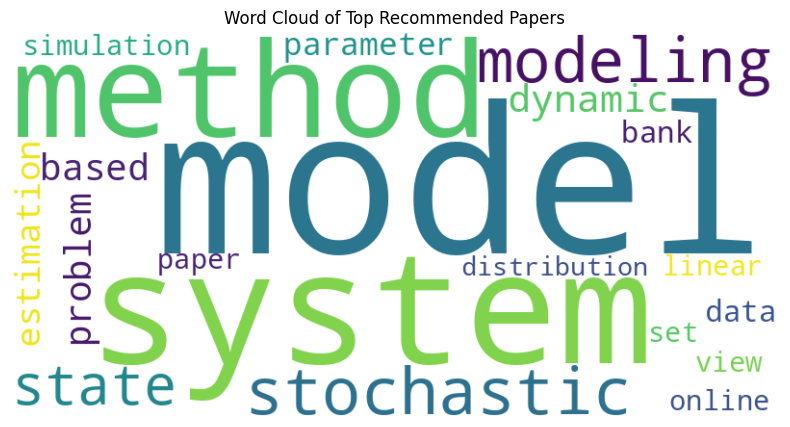

In [9]:
# Function to recommend top n papers (default to top_n=10)
def selectPapers(query:str, top_n:int=10):
    # Embed query string using Universal Serial Encoder
    queryEmbeddings:npt.NDArray = embed([query]).numpy()
    # Define lists
    corrMeanList:list[float] = []
    corrMedList:list[float] = []
    simsList:list[npt.NDArray] = []
    topList:list[list[int]] = []
    cosMeanList:list[float] = []
    cosMedList:list[float] = []
    tfidfList:list[npt.NDArray] = []
    testVecList:list[npt.NDArray] = []
    topVecList:list[npt.NDArray] = []

    # Determine the closest cluster for the current test paper
    distances:list = []
    for clusterID in range(bestN):
        clusterPoints:pd.DataFrame = trnDF.drop(
            columns=["cluster"]
        ).loc[trnDF["cluster"] == clusterID]
        centroid:npt.NDArray = np.array(
            np.mean(clusterPoints, axis=0)
        ).reshape(1, -1)
        currDist:float = euclidean_distances(
            queryEmbeddings,
            centroid
        )[0][0]
        distances.append(currDist)
    closestCluster:float = np.argmin(distances)
    # Get similarities of all training papers in the same cluster
    sameClusterPapers:pd.DataFrame = trnDF.drop(
        columns=["cluster"]
    )[trnDF["cluster"] == closestCluster]
    currSims:npt.NDArray = cosine_similarity(
        queryEmbeddings,
        sameClusterPapers.values
    )[0]
    # Get top-N most similar papers, highest similarity first
    topIndices:npt.NDArray = np.argsort(currSims)[::-1][:top_n]
    topPapers:list[int] = sameClusterPapers.iloc[
        topIndices
    ].index.tolist()
    topEmbeddings:npt.NDArray = sameClusterPapers.iloc[
        topIndices
    ].values
    
    # Print top 10 recommendations for current paper:
    print(f"Top 10 papers for query '{query}':")
    print(cleanedDF.iloc[topPapers])
    
    # Compute cosine similarity
    similarities:npt.NDArray = cosine_similarity(
        queryEmbeddings, topEmbeddings
    )
    # Pearson correlation
    corrMean, corrMedian = compute_pearson_correlation(
        queryEmbeddings, topEmbeddings.reshape(1, top_n, -1)
    )
    # Cosine similarity score 
    cosMean, cosMedian = cosine_similarity_mean_median(similarities)
    # TF-IDF
    (
        tfidfQueryMatrix, queryVectors, topSelectedVectors
    ) = compute_tfidf_similarity(
        test_texts=cleanedDF.loc[[0], "abstract"].tolist(),
        top10_texts=[cleanedDF.loc[idx, "abstract"] for idx in topPapers]
    )
    # Generate wordCloud object
    currWCObj:WordCloud = createWCloud(
        paper_ids=cleanedDF.iloc[topPapers]["id"].to_list(),
        papers=cleanedDF
    )
    # Store values for each index
    corrMeanList.append(corrMean[0])
    corrMedList.append(corrMedian[0])
    simsList.append(similarities[0])
    cosMeanList.append(cosMean[0])
    cosMedList.append(cosMedian[0])
    topList.append(topPapers)
    tfidfList.append(tfidfQueryMatrix)
    testVecList.append(queryVectors)
    topVecList.append(topSelectedVectors)
    # Return data
    return pd.DataFrame({
        "correlation_mean": corrMeanList,
        "correlation_median": corrMedList,
        "cosine_similarity": simsList,
        "cosine_mean": cosMeanList,
        "cosine_median": cosMedList,
        "top_paper_indices": topList,
        "tfidf_matrix": tfidfList,
        "test_vectors": testVecList,
        "top_vectors": topVecList
    })

# Test on new papers
queryDF:pd.DataFrame = selectPapers(query="stochastic hybrid system modeling", top_n=10)
queryDF[[
    "correlation_mean", "correlation_median", "cosine_mean",
    "cosine_median", "top_paper_indices"
]].to_csv("./dump/query.csv")

## TF-IDF and Feature Importance Plot

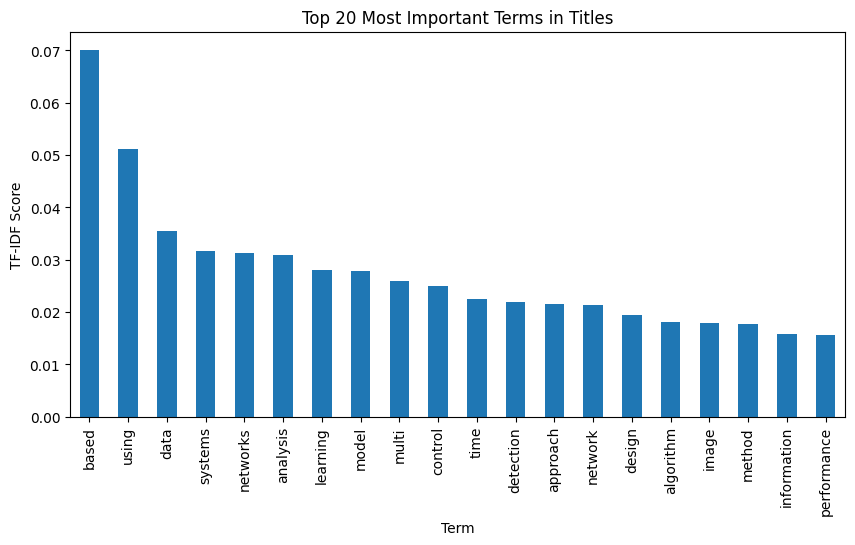

In [10]:
# Convert titles into TF-IDF representation
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = vectorizer.fit_transform(cleanedDF["title"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out()
)

# Plot top 20 TF-IDF terms
tfidf_df.mean().nlargest(20).plot(kind='bar', figsize=(10, 5))
plt.title("Top 20 Most Important Terms in Titles")
plt.xlabel("Term")
plt.ylabel("TF-IDF Score")
plt.show()